#To be removed - Only for highlighting flow
1. mount drive
2. import os and other necessary packages
3. Load the 2 csv files and observe them
4. See what columns we need to retain and what can be done away with
5. determine the balance in data based on pneumonia and non-pneumonia cases
6. balance if required and then extract information for the new balanced dataset
7. visually plot the pneumonia and non-pneumonia cases across gender and age group.
8. Create new dataset merging all the data
9. develop a model which has 2 outputs - object detection and binary classification. 


##Pneumonia Detection Model
The goal of this project is to build a pneumonia detection computer vision model, to locate the position of inflammation in an image and help in diagnosis of Pneumonia. The model will have an algorithm to detect a visual signal for pneumonia in medical images. It will locate lung opacities on chest radiographs providing affected area details through bounding box. And the image with such bounding boxes are detected as having Pneumonia and can be subject to further investigation by domain expert.

##The Dataset
The dataset contains images with details in DICOM® format. DICOM® (Digital Imaging and Communications in Medicine) is the international standard to transmit, store, retrieve, print, process, and display medical imaging information. The data set that has been shared has 26684 training and 3000 test X-ray images. The images are annotated with bounding boxes to highlight the region in the X-ray that is indicative of possible Pneumonia.



In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
project_path = "/content/gdrive/My Drive/Colab Notebooks/Capstone Project"
data_path = "/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data"


In [3]:
#install pydicom module if it has not been installed already
pydicom_exists = !ls /usr/local/lib/python3.6/dist-packages | grep pydicom

if(len(pydicom_exists) == 0):
  !pip install pydicom

     |████████████████████████████████| 35.1MB 120kB/s 


In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pydicom as dcm
from PIL import Image

## Exploring the given Data files, classes and images of different classes.

In [5]:
patient_classes = pd.read_csv(data_path + "/stage_2_detailed_class_info.csv")
patient_classes.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [6]:
print("Unique Class names in the data set \n", patient_classes["class"].unique())

Unique Class names in the data set 
 ['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']


As we can see, based on the opacity of lungs in the X-Ray of the chest, they are classified into 3 categories:

**Normal** (Healthy lungs)

**No Lung Opacity/Not Normal** (unhealthy lungs but not indicative of Pneumonia)

**Lung Opacity** (Indicative of pneumonia)



In [7]:
train_labels = pd.read_csv(data_path + "/stage_2_train_labels.csv")
train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [8]:
print("Unique Target names in the data set \n", train_labels["Target"].unique())

Unique Target names in the data set 
 [0 1]


**patient_classes** dataset has information about the patient id and the classification of the patient's X-Ray into one of the three possible classes. 

**train_labels** dataset provides the position of pneumonia in the lung in the form of (x,y) starting point of the opacity on the image followed by the width and height of the opacity. It also has a Target column which has values 0 if the patient is not diagnosed for pneumonia and 1 otherwise. Those patients with a target of 0 (no pneumonia) do not have binding box values. These binding boxes are needed to train models to perform object detection, where the location of the object will be highlighted.

Let's try to retrieve the number of unique patient records where the target is 1, meaning the patient has pneumonia. 

In [9]:
print(len(np.unique((train_labels[train_labels['Target'] == 1])['patientId'])))

6012


So we have 6012 patients each of who have one or more than one lung opacity, which is indicative of Pneumonia.

In this case study model building, our focus is only to detect the cases of pneumonia. Any abnormality other than pneumonia is beyond the scope of the model we are building. Let's determine the relation between the class and target before proceeding further. For this purpose, we will merge the two datasets and analyse.

In [10]:
patientInfo_df = pd.merge(train_labels, patient_classes, left_on='patientId', right_on='patientId', how='inner')
patientInfo_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


3


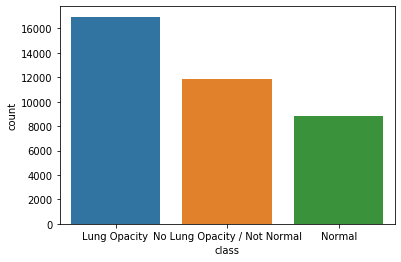

In [11]:
class_count = len(np.unique(patientInfo_df['class']))
print(class_count)
sns.countplot(patientInfo_df['class'],order = np.unique(patientInfo_df['class']))
plt.show()

In [12]:
print(np.unique((patientInfo_df[patientInfo_df['Target'] == 0])['class']))

['No Lung Opacity / Not Normal' 'Normal']


In [13]:
print(np.unique((patientInfo_df[patientInfo_df['Target'] == 1])['class']))

['Lung Opacity']


It is evident from the print statements that all the records belonging to class 'Normal' and 'No Lung Opacity / Not Normal' come under Target 0, which indicates the X-ray under subject is not diagnosed for Pneumonia and all the records belonging to class 'Lung Opacity' come under Target 1. 

We will remove the records which are classified as 'Not Normal' as they have no opacity and are not subject of interest for our model building.

In [0]:
patientInfo_df.drop(patientInfo_df[patientInfo_df['class'] == 'No Lung Opacity / Not Normal'].index, inplace = True)  


As the objective of our model is only to identify whether an X-ray image has opacities which are indicative of Pneumonia or not, we are only concerned about the Target column. We can leave out the class column from our model-building. 

In [0]:
patientInfo_df.drop('class',axis=1,inplace=True)

##Number of patients with no pneumonia

In [16]:
numNonPneumoniaPatients = len(np.unique((patientInfo_df[patientInfo_df['Target'] == 0])['patientId']))
print(numNonPneumoniaPatients)

8851


## Number of patients with pneumonia

In [17]:

numPneumoniaPatients = len(np.unique((patientInfo_df[patientInfo_df['Target'] == 1])['patientId']))
print(numPneumoniaPatients)

6012


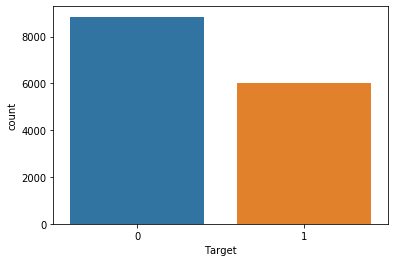

In [18]:
tmp_dataset = patientInfo_df.drop_duplicates(subset="patientId",keep = 'last', inplace = False) 
sns.countplot(tmp_dataset['Target'],order = tmp_dataset['Target'].value_counts().index)
plt.show()

# Dealing with Missing values

We have to check if any label that is of the +ve class has Nulls in the bounding boxes data. Since only bounding boxes in the 0 class can have nulls since we will not draw bounding boxes in these cases.

In [19]:
print("The number of NaN values for bounding box dimentions columns for class 1 data = %s " % patientInfo_df[patientInfo_df.Target == 1].isna().sum() )


The number of NaN values for bounding box dimentions columns for class 1 data = patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64 


There are no null values in the dataset for patients with pneumonia which means the bounding boxes for the opacity is present for all patients who are diagnosed positive for pneumonia. 

In [20]:
print(len(np.unique(patientInfo_df[patientInfo_df.Target == 1]['patientId'])))

6012


In [21]:
patientInfo_df.head(10)

,patientId,x,y,width,height,Target
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
6,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
7,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
10,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
11,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
12,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
13,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
15,009482dc-3db5-48d4-8580-5c89c4f01334,NaN,NaN,NaN,NaN,0


Exploring images

Input images are stored in DICOM format which stores description for every image in the dataset. 

In [23]:
dcm_file = project_path + '/data/stage_2_train_images/%s.dcm' % patientInfo_df.patientId.tolist()[0]
dcm_data = dcm.read_file(dcm_file)
print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.2293.1517874295.733882
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '003d8fa0-6bf1-40ed-b54c-ac657f8495c5'
(0010, 0020) Patient ID                          LO: '003d8fa0-6bf1-40ed-b54c-ac657f8495c5'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's

Most of the information doesn't seem to be useful except Age and Gender.

Let us merge all the meta data information also with patientInfo dataframe for further analysis and usage

In [24]:
%cd /content/gdrive/My Drive/Colab Notebooks/Capstone Project/data
PATH = "/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/"

if not os.path.exists('training_images'):
    os.makedirs('training_images')
if not os.path.exists('test_images'):
    os.makedirs('test_images')


/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data


In [25]:
def process_dicom_data(data_df):
    for idx, data_row in data_df.iterrows():
        imgName = str(data_row['patientId'])
        imagePath = PATH+"stage_2_train_images/"+imgName+".dcm"
        try:
          data_row_img_data = dcm.read_file(imagePath)
          data_row_img = dcm.dcmread(imagePath)
          jpegFileName = "./training_images/"+imgName+".jpg"
          if not os.path.exists(jpegFileName):
            img = Image.fromarray(data_row_img.pixel_array)
            img.save(jpegFileName)
          idx = (data_df['patientId']==data_row_img_data.PatientID)
          data_df.loc[idx,'Image'] = imgName+".jpg"
          data_df.loc[idx,'Modality'] = data_row_img_data.Modality
          data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
          data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
          data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
          data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
          data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
          data_df.loc[idx,'Rows'] = data_row_img_data.Rows
          data_df.loc[idx,'Columns'] = data_row_img_data.Columns  

          data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0]) 
        except:
          print("Exception in reading DICOM for patient ",imgName)
          continue


if not os.path.exists("./patients_data.csv"):
  process_dicom_data(patientInfo_df)
  patientInfo_df.to_csv("./patients_data.csv")
else:
  patientInfo_df = pd.read_csv('patients_data.csv')


   Unnamed: 0                             patientId  ...  Columns  PixelSpacing
0           3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...   1024.0         0.143
1           4  00436515-870c-4b36-a041-de91049b9ab4  ...   1024.0         0.139
2           5  00436515-870c-4b36-a041-de91049b9ab4  ...   1024.0         0.139
3           6  00436515-870c-4b36-a041-de91049b9ab4  ...   1024.0         0.139
4           7  00436515-870c-4b36-a041-de91049b9ab4  ...   1024.0         0.139

[5 rows x 17 columns]


# Visualizing different classes

Drawing bounding boxes on images

<Figure size 432x288 with 0 Axes>

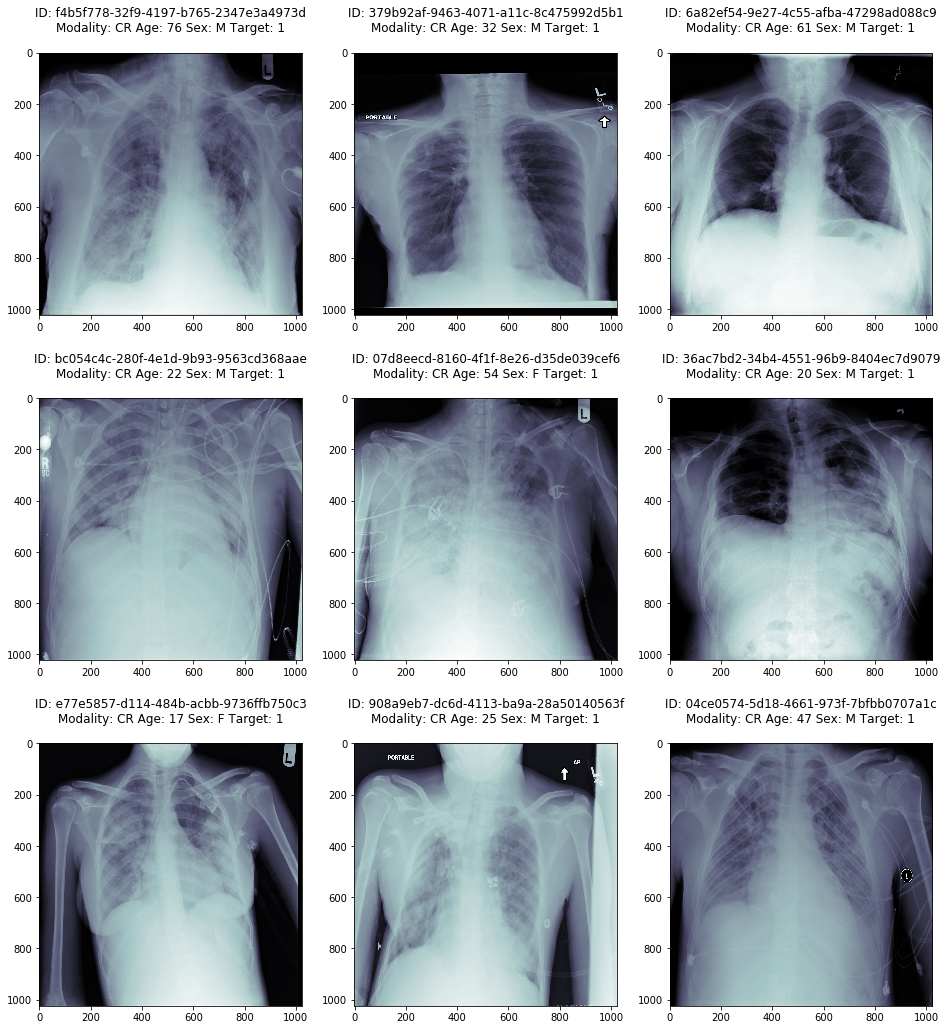

In [26]:
samplePatientIDList = patientInfo_df[patientInfo_df['Target'] == 1].sample(9)
f = plt.figure()

f, ax = plt.subplots(3,3, figsize=(16,18))

def show_dicom_images(data_set):
    i=0
    for idx,data_row in data_set.iterrows():
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\n'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target']))
        i = i+1
    
show_dicom_images(samplePatientIDList)
plt.show()


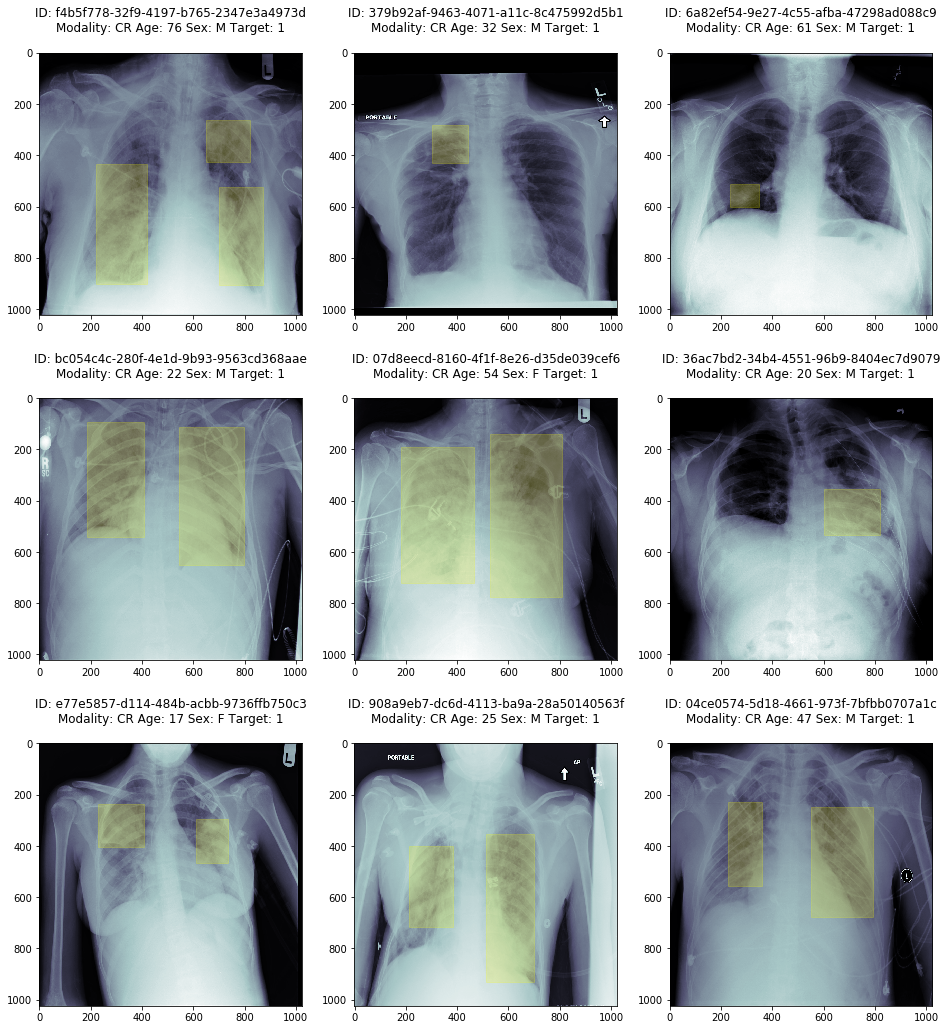

In [27]:
def show_opactiy_boxes(data_set):
  i=0
  for idx,data_row in data_set.iterrows():

    rows = train_labels[train_labels['patientId']==data_row['patientId']]
    box_data = list(rows.T.to_dict().values())
    for j, row in enumerate(box_data):
      ax[i//3, i%3].add_patch(patches.Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color='yellow', alpha = 0.2))   
    i=i+1  

show_opactiy_boxes(samplePatientIDList)

f

In [28]:
patientInfo_df.head()

,Unnamed: 0,patientId,x,y,width,height,Target,Image,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing
0,3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.jpg,CR,28.0,M,CHEST,PA,WSD,1024.0,1024.0,0.143
1,4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,00436515-870c-4b36-a041-de91049b9ab4.jpg,CR,32.0,F,CHEST,AP,WSD,1024.0,1024.0,0.139
2,5,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,00436515-870c-4b36-a041-de91049b9ab4.jpg,CR,32.0,F,CHEST,AP,WSD,1024.0,1024.0,0.139
3,6,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,00436515-870c-4b36-a041-de91049b9ab4.jpg,CR,32.0,F,CHEST,AP,WSD,1024.0,1024.0,0.139
4,7,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,00436515-870c-4b36-a041-de91049b9ab4.jpg,CR,32.0,F,CHEST,AP,WSD,1024.0,1024.0,0.139


In [29]:
# number of unique patients
print ("Total no. of unique pateints", patientInfo_df['patientId'].nunique())

Total no. of unique pateints 14863


Let's create a dataset from the balanced_patient_dataset which only has the columns we are going to take into consideration for solely visual analysis purpose. 

In [0]:

tmp_dataset = patientInfo_df[['patientId','PatientAge','PatientSex','Target']]

In [0]:
tmp_dataset = tmp_dataset.drop_duplicates(subset="patientId",keep='last',inplace=False)

In [38]:
tmp_dataset.head(5)

,patientId,PatientAge,PatientSex,Target
0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,28.0,M,0
4,00436515-870c-4b36-a041-de91049b9ab4,32.0,F,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,75.0,M,1
9,009482dc-3db5-48d4-8580-5c89c4f01334,63.0,M,0
10,009eb222-eabc-4150-8121-d5a6d06b8ebf,54.0,F,0


Target
0    0.595506
1    0.404494
dtype: float64
0    8851
1    6012
Name: Target, dtype: int64


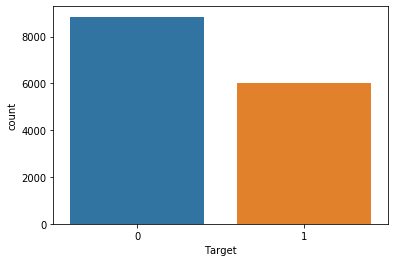

In [39]:
sns.countplot(tmp_dataset['Target'])
print(tmp_dataset.groupby('Target').size() / tmp_dataset.shape[0])
print(tmp_dataset['Target'].value_counts())

M    8455
F    6407
Name: PatientSex, dtype: int64


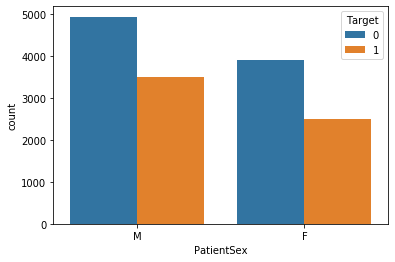

In [51]:
#Breakup of the dataset w.r.t their sex
print(tmp_dataset['PatientSex'].value_counts())

#multivariant analysis to see the spread of sex w.r.t if they have pneumonia or non-pneumonia patient
sns.countplot(x = 'PatientSex', hue = 'Target', data = tmp_dataset)

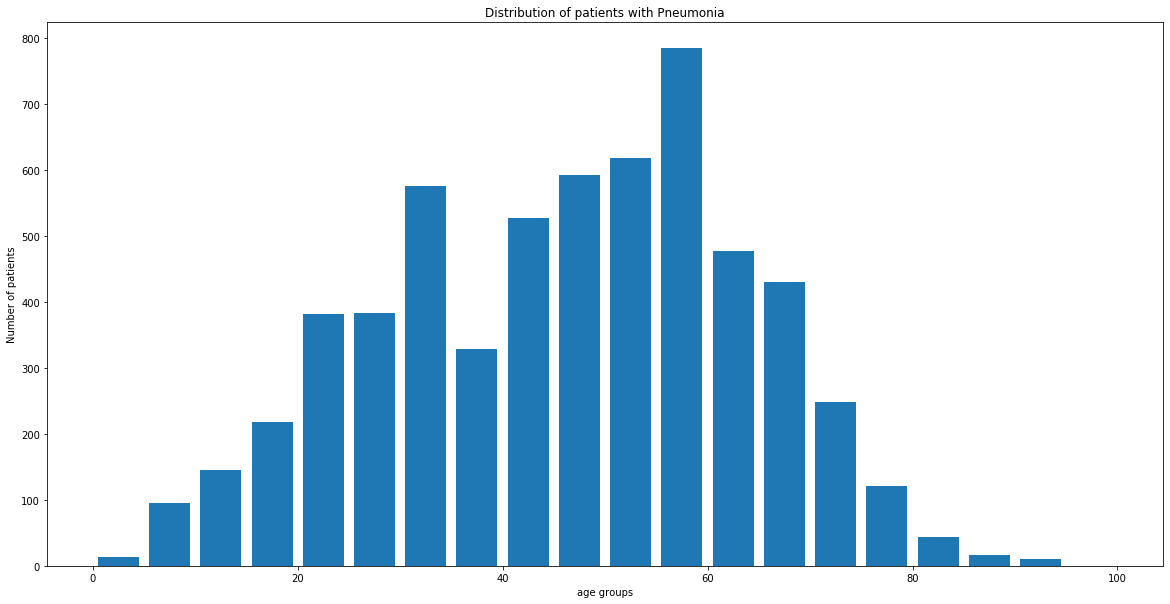

In [53]:
bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
plt.figure(figsize=(20,10))
plt.hist(tmp_dataset[tmp_dataset['Target'] == 1]['PatientAge'], bins, histtype='bar', rwidth=.8)
plt.xlabel('age groups')
plt.ylabel('Number of patients')
plt.title('Distribution of patients with Pneumonia')
plt.show()

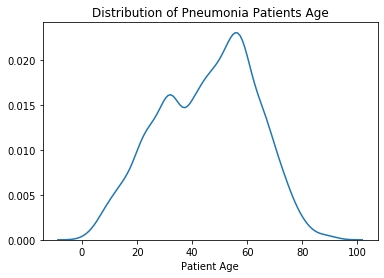

In [57]:
# Same is visualized using a density plot
# there is a bi-modal distribution seen wherein we have 2 peaks
sns.kdeplot(tmp_dataset[tmp_dataset['Target'] == 1]['PatientAge'].values).set_title("Distribution of Pneumonia Patients Age")
plt.xlabel('Patient Age')
plt.show()

Below boxplot shows that there are 2 outliners at the upper end (PatientAge > 92) and 1 outline at the lower end (PatientAge < 1). The latter outliner is due to the update done to convert NaN to 0

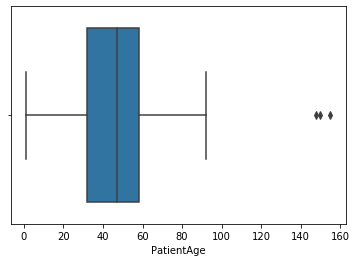

In [60]:
sns.boxplot(tmp_dataset['PatientAge'])
plt.show()


We can see that we have some outliers in Age. This might be due to incorrect entry of data or actual outlier. But for the purpose of this model building, age doesn't have correlation in detection of pneumonia. We will not treat the outliers. 